In [ ]:
# Josh McGiff - 19250363 , Shane Slattery - 19235046
# Code executes to end without error
# Implementation based on a variety of sources: https://github.com/AnujaKatkar/OpenAI-Gym-Breakout-Env, https://github.com/vilcek/DQN_PyTorch, https://github.com/GiannisMitr/DQN-Atari-Breakout, https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756, https://github.com/fg91/Deep-Q-Learning

# Dueling Double DQN - Atari Breakout

In [1]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117 #CUDA versions of pytorch
#!pip install ale_py
#!pip install gym[atari,accept-rom-license]

In [2]:
import random
import statistics
import gym
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import math

from collections import OrderedDict, deque
from tqdm import tqdm
from PIL import Image

%matplotlib inline

In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [4]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [5]:
# Parameters
output_rgb = False
render_mode = "rgb_array"
#render_mode = "human"

env = gym.make('ALE/Breakout-v5', render_mode=render_mode)
env.metadata['render_fps'] = 60

print(env.unwrapped.get_action_meanings())

state_size = env.observation_space.shape
action_size = env.action_space.n

epsilon = 1.0
epsilon_decay = 0.0001

batch_size = 32
lr = 0.00025
discount_factor = 0.99
update_frequency = 5

memory_len = 30000
episodes = 30000
test_episodes = 100

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [6]:
if not os.path.isdir("output"):
    os.mkdir("output")

if render_mode == "rgb_array" and output_rgb is True:
    if not os.path.isdir("output/images"):
        os.mkdir("output/images")

    if not os.path.isdir("output/images_test"):
        os.mkdir("output/images_test")

    for episode in range(episodes):
        if not os.path.isdir(f"output/images/{episode}"):
            os.mkdir(f"output/images/{episode}")

    for episode in range(test_episodes):
        if not os.path.isdir(f"output/images_test/{episode}"):
            os.mkdir(f"output/images_test/{episode}")

In [8]:
# This class defines the neural network structure for Deep Q
class DQNnet(nn.Module):
    def __init__(self,num_actions, lr):
        super(DQNnet, self).__init__()  # nn.Module super class
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        std = math.sqrt(2.0 / (4 * 84 * 84))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=std)
        self.conv1.bias.data.fill_(0.0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        std = math.sqrt(2.0 / (32 * 4 * 8 * 8))
        nn.init.normal_(self.conv2.weight, mean=0.0, std=std)
        self.conv2.bias.data.fill_(0.0)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        std = math.sqrt(2.0 / (64 * 32 * 4 * 4))
        nn.init.normal_(self.conv3.weight, mean=0.0, std=std)
        self.conv3.bias.data.fill_(0.0)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        std = math.sqrt(2.0 / (64 * 64 * 3 * 3))
        nn.init.normal_(self.fc1.weight, mean=0.0, std=std)
        self.fc1.bias.data.fill_(0.0)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, num_actions)
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=lr)

    # Performs forward pass in the network
    def forward(self, state_size):
        x = F.relu(self.conv1(state_size))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))  # Flatten input.
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

In [19]:
'''
Initital two DQN networks - one is the policy network and the other is the target network
'''
class DQNagent:
    def __init__(self, state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.1
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Double Dueling
        self.policy_net = DQNnet(self.action_size, lr).to(self.device)
        self.target_net = DQNnet(self.action_size, lr).to(self.device)

        #Double
        #self.policy_net = DQNetwork(self.action_size, lr).to(self.device)
        #self.target_net = DQNetwork(self.action_size, lr).to(self.device)
        
        self.update_target_policy()

    '''
    Function definition for choosing an action based on ɛ-greedy policy. 
        i.e For P(1-ɛ) => argmax(Qt(a))
        else for P(ɛ) => random(a)
    '''
    def get_action(self, current_state_vector):
        rand_num = np.random.random()
        if rand_num < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if not torch.is_tensor(current_state_vector):
                current_state_vector = torch.from_numpy(current_state_vector).float().to(self.device)
            
            with torch.no_grad():
                q_values = self.policy_net.forward(current_state_vector).view(-1,)
            best_action = torch.argmax(q_values).item()
        return best_action
    
    '''
    Save each experience in the replay memory
    '''
    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    '''
    Update the target network parameters based on the policy network parameters
    '''
    def update_target_policy(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    '''
    Implements epsilon decay
    '''
    def update_epsilon(self):
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        return self.epsilon
    
    '''
    Apply preprocessing to the captured frame/state
    '''
    def preprocess_state(self, state):
        img = state[34:-16, :, :]
        resize = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((84, 84)),
                    T.ToTensor()
                ])
        img = resize(img)
        return img.to(self.device)

    '''
    Train the neural network
    '''
    def train_model(self):
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = torch.tensor([]).float().to(self.device)
            actions = list()
            rewards = list()
            next_states = torch.tensor([]).float().to(self.device)
            dones = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                current_state = torch.cat((current_state, state)).float().to(self.device)
                actions.append(action)
                rewards.append(reward)
                next_states = torch.cat((next_states, next_state)).float().to(self.device)
                dones.append(done_boolean)
            
            # Convert each list to torch tensors
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)

            # Make a forward pass in the policy network based on the current state
            # and choose the q-value of the action
            policy_q_values = self.policy_net.forward(current_state).gather(1, actions.view(-1,1).type(torch.int64)).view(-1,)

            # Make a forward pass in the target network based on the next state
            # and choose the q-value of the action which gives the highest q-value
            policy_best_actions = self.policy_net.forward(next_states).argmax(dim=1).view(-1,1)
            target_q_values = self.target_net.forward(next_states).gather(1, policy_best_actions).view(-1,)
            
            # Compute the target
            y_target = list()
            for index, value in enumerate(target_q_values):
                if dones[index]:
                    y_target.append(rewards[index])
                else:
                    y_target.append(rewards[index] + self.discount_factor * value)
            
            y_target = torch.stack(y_target, dim=0) # Create the list to torch tensor

            # Calculate the MSE loss and perform a backward pass in the policy network
            criterion = nn.HuberLoss()
            loss = criterion(y_target, policy_q_values)
            self.policy_net.optimizer.zero_grad()
            loss.backward()

            self.policy_net.optimizer.step()
    
    '''
    Test the agent behavior after it has been trained
    Agent follows only the greedy policy
    '''
    def test_model(self, agent, env, episodes):
        
        # print('\nTesting the agent after it has been trained')
        # print('Agent chooses only greedy actions from the learnt policy')
        
        total_reward_arr = list()
        self.epsilon = 0
        
        for episode in tqdm(range(episodes)):
            current_state = env.reset()
            frame = 0

            obs, _, _, _, _ = env.step(1) #1 is FIRE action
            
            current_state = agent.preprocess_state(obs)
            current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0)

            dead = False
            done = False
            total_reward = 0
            agent_lives = 5
            
            while not done:
                action = self.get_action(current_state)

                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated | truncated

                renderOutput = env.render()
                if render_mode == "rgb_array":
                    new_im = Image.fromarray(renderOutput)
                    new_im.save(f"output/images_test/{episode}/frame_{frame}.png")
                    frame += 1

                next_state = agent.preprocess_state(next_state) # 84-84
                next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84

                if agent_lives > info['lives']:
                    dead = True
                    agent_lives = info['lives']

                if dead:
                    obs, _, _, _, _ = env.step(1)
                    
                    obs = agent.preprocess_state(obs)
                    current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
                    dead = False
                else:
                    current_state = next_state_history

                total_reward += reward
                # current_state = next_state
                
                env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr
    
    '''
    Save the trained model
    '''
    def save_model(self, filename):
        torch.save(self.policy_net.state_dict(), filename)
    
    '''
    Load the model
    '''
    def load_model(self, filename):
        self.policy_net.load_state_dict(torch.load(filename))

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

total_reward_arr = list() # Store total reward per episode values
cumulative_reward_arr = list() # Store cumulative reward
epsilon_decay_arr = [epsilon] # Store each epsilon value after decay
timestep_arr = list() # Store the timestep per episode
avg_timestep_arr = list() # Store average timestep every 20 episodes
test_total_reward_arr = list()

agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
success_count = 0
failure_count = 0
train_timestep = 4

for episode in tqdm(range(episodes)):
    done = False
    dead = False
    # perform_fire = True

    total_reward = 0
    timesteps = 0
    agent_lives = 5
    current_state = env.reset() 

    obs, _, _, _, _ = env.step(1)
    
    current_state = agent.preprocess_state(obs)
    current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0) # 1-4-84-84
    #print(f'\nEpisode: {episode}, Agent Lives: {agent_lives}')
    
    while not done:        
        action = agent.get_action(current_state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated|truncated

        renderOutput = env.render()
        if render_mode == "rgb_array" and output_rgb is True:
            new_im = Image.fromarray(renderOutput)
            new_im.save(f"images/{episode}/frame_{timesteps+1}.png")

        next_state = agent.preprocess_state(next_state) # 84-84
        next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84
        
        agent.append_memory(current_state, action, reward, next_state_history, done)

        if agent_lives > info['lives']:
            dead = True
            agent_lives = info['lives']

        if timesteps % train_timestep == 0:
            agent.train_model()

        total_reward += reward
        timesteps += 1
        
        if dead:
            obs, _, _, _, _ = env.step(1)
            
            obs = agent.preprocess_state(obs)
            current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
            dead = False
        else:
            current_state = next_state_history

    if episode % update_frequency == 0:
        agent.update_target_policy()

    epsilon = agent.update_epsilon()
    epsilon_decay_arr.append(epsilon)

    timestep_arr.append(timesteps)

    if (episode+1) % 500 == 0: # Output results every 500 episodes
        nparr = np.asarray(total_reward_arr).astype(int)
        np.savetxt(f'output/live_reward_arr.txt', nparr, fmt='%i', delimiter='\n')

    # Calculate average timesteps for 50 timesteps
    if done and (episode+1) % 50 == 0:
        avg_timestep_arr.append(np.average(timestep_arr))
        timestep_arr.clear()

    total_reward_arr.append(total_reward)

    if len(cumulative_reward_arr) == 0:
        cumulative_reward = total_reward
    else:
        cumulative_reward = cumulative_reward_arr[-1] + total_reward
    cumulative_reward_arr.append(cumulative_reward)


100%|██████████| 30000/30000 [15:51:10<00:00,  1.90s/it]  


In [11]:
agent.save_model("output/Double_DQN_breakout_weights.pth")

# Add experience to the experience replay deque

In [12]:
arr = np.asarray(total_reward_arr).astype(int)
c = np.savetxt('duelingtotal_reward_arr.txt', arr, fmt='%i', delimiter='\n')

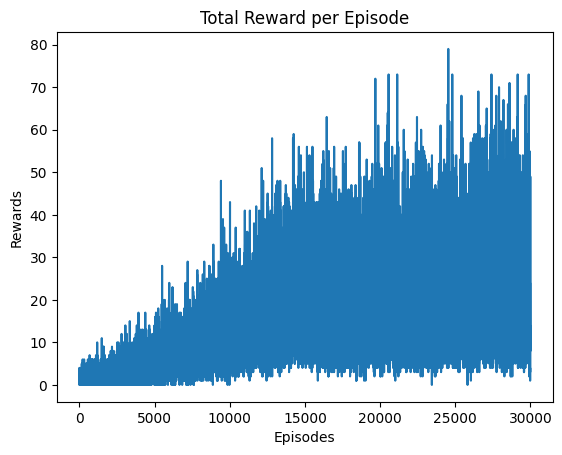

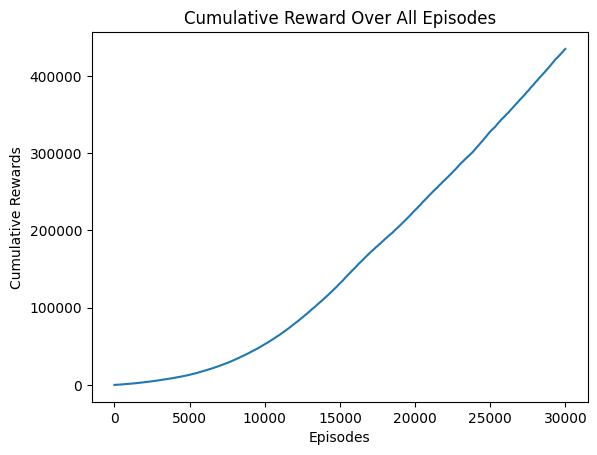

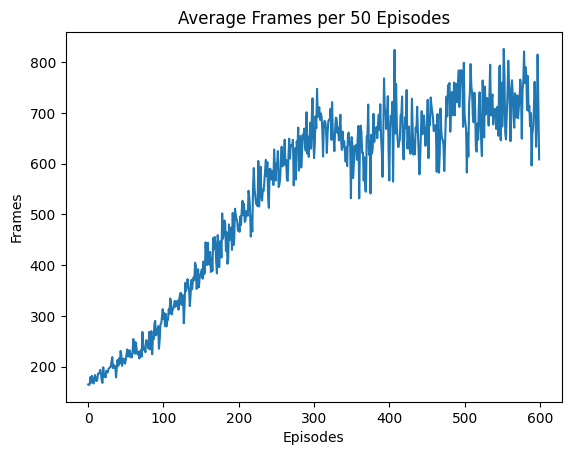

In [13]:
plt.plot(total_reward_arr)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.savefig('output/reward_per_episode.png', bbox_inches="tight")
plt.show()
plt.close()

plt.plot(cumulative_reward_arr)
plt.title('Cumulative Reward Over All Episodes')
plt.ylabel('Cumulative Rewards')
plt.xlabel('Episodes')
plt.savefig('output/cumulative_reward_overall.png', bbox_inches="tight")
plt.show()
plt.close()

plt.plot(avg_timestep_arr)
plt.title('Average Frames per 50 Episodes')
plt.xlabel('Episodes')
plt.ylabel('Frames')
plt.savefig('output/avg_frames_per_50episodes.png', bbox_inches="tight")
plt.show()
plt.close()

In [14]:
arr = np.asarray(total_reward_arr).astype(int)
c = np.savetxt('output/total_reward_arr.txt', arr, fmt='%i', delimiter='\n')
print(statistics.mean(total_reward_arr))
print(arr)

14.497866666666667
[ 1  3  0  1  4  3  1  1  2  1  1  2  1  1  1  1  4  0  4  0  0  3  1  1
  0  0  1  2  1  0  0  0  2  0  1  1  2  2  0  2  0  1  0  2  1  0  1  0
  1  2  0  0  1  2  3  1  1  2  0  2  0  1  2  3  2  1  1  2  0  1  2  1
  1  0  1  0  0  1  3  0  0  3  0  2  1  1  1  0  1  2  1  0  0  3  3  0
  1  2  0  1  0  2  4  2  1  2  2  1  0  0  1  3  1  0  2  0  2  1  2  0
  1  1  2  1  0  2  2  1  1  0  1  0  0  4  0  0  1  0  1  3  2  0  0  2
  2  1  1  0  4  1  2  2  5  0  3  5  0  0  0  1  3  3  2  2  2  0  0  3
  2  0  2  1  1  2  2  3  2  0  1  2  1  0  0  3  0  3  3  0  2  1  3  3
  0  0  1  0  2  1  3  0  2  0  3  0  0  2  1  0  3  0  3  6  2  0  0  2
  1  4  1  2  1  1  0  2  2  1  1  1  0  0  0  1  1  2  1  1  4  1  3  2
  0  2  1  0  1  0  1  0  2  0  0  2  2  1  0  1  1  1  2  1  0  1  1  1
  3  2  0  1  1  0  3  3  1  2  2  0  3  3  1  2  0  2  1  2  3  3  2  3
  1  3  0  2  1  2  3  4  2  1  4  1  0  2  2  1  2  0  6  1  2  1  1  1
  6  0  1  0  2  2  2  0  1  2  

### Load saved model weights and test the agent for 100 episodes

In [22]:
agent = DQNagent(state_size, action_size, epsilon, epsilon_decay, batch_size, lr, discount_factor, memory_len)
agent.load_model("output/Double_DQN_breakout_weights.pth")
test_rewards = agent.test_model(agent, env, test_episodes)

100%|██████████| 100/100 [08:31<00:00,  5.12s/it]


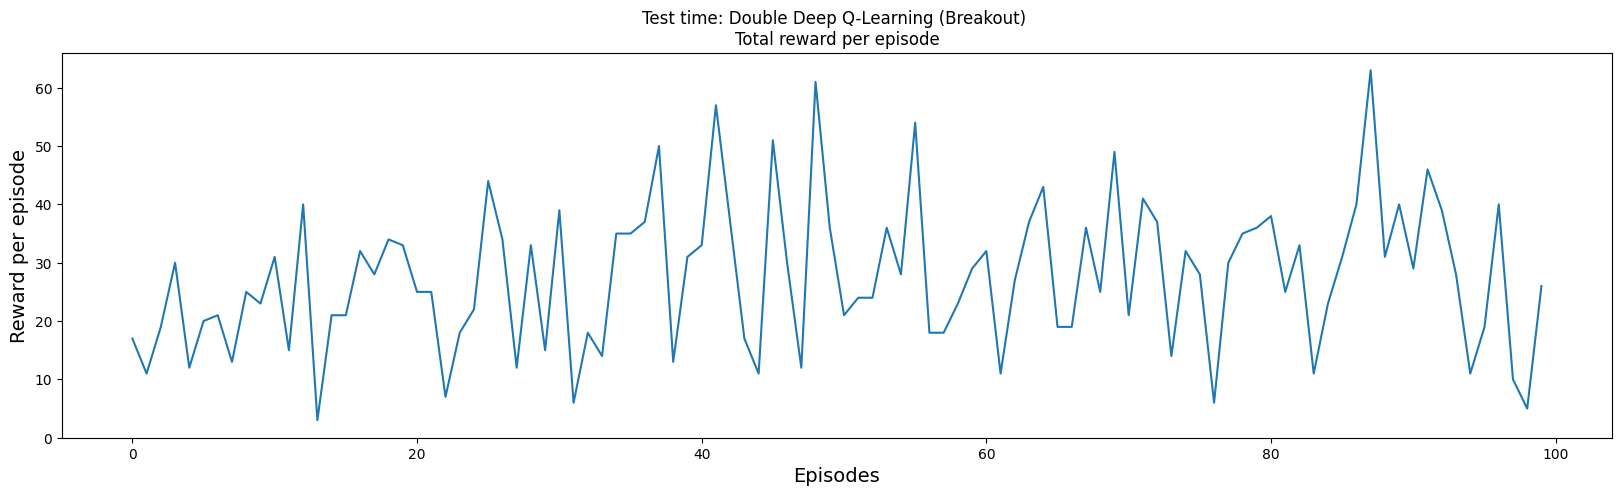

In [23]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_rewards)
plt.title('Test time: Double Deep Q-Learning (Breakout) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.show()

In [18]:
print(agent.policy_net)

DQNnet(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (V): Linear(in_features=512, out_features=1, bias=True)
  (A): Linear(in_features=512, out_features=4, bias=True)
)
